In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib  inline

2024-05-31 12:51:56.500595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 12:51:56.500763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 12:51:56.640668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
mask=np.array(Image.open("/kaggle/input/word-cloud-5/word-cloud-mask.jpg"))

In [3]:
with open ('/kaggle/input/sherlock-holmes/sherlock-holm.es_stories_plain-text_advs.txt','r',encoding='utf-8') as file:
    
    text=file.read()

In [4]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [5]:
words=text.split()
num_words=len(words)
unique_words=len(set(words))
print("##################################################################")
print("Total Words : {}".format(num_words))
print("##################################################################")
print("Unique Words : {}".format(unique_words))
print("##################################################################")

##################################################################
Total Words : 104527
##################################################################
Unique Words : 14654
##################################################################


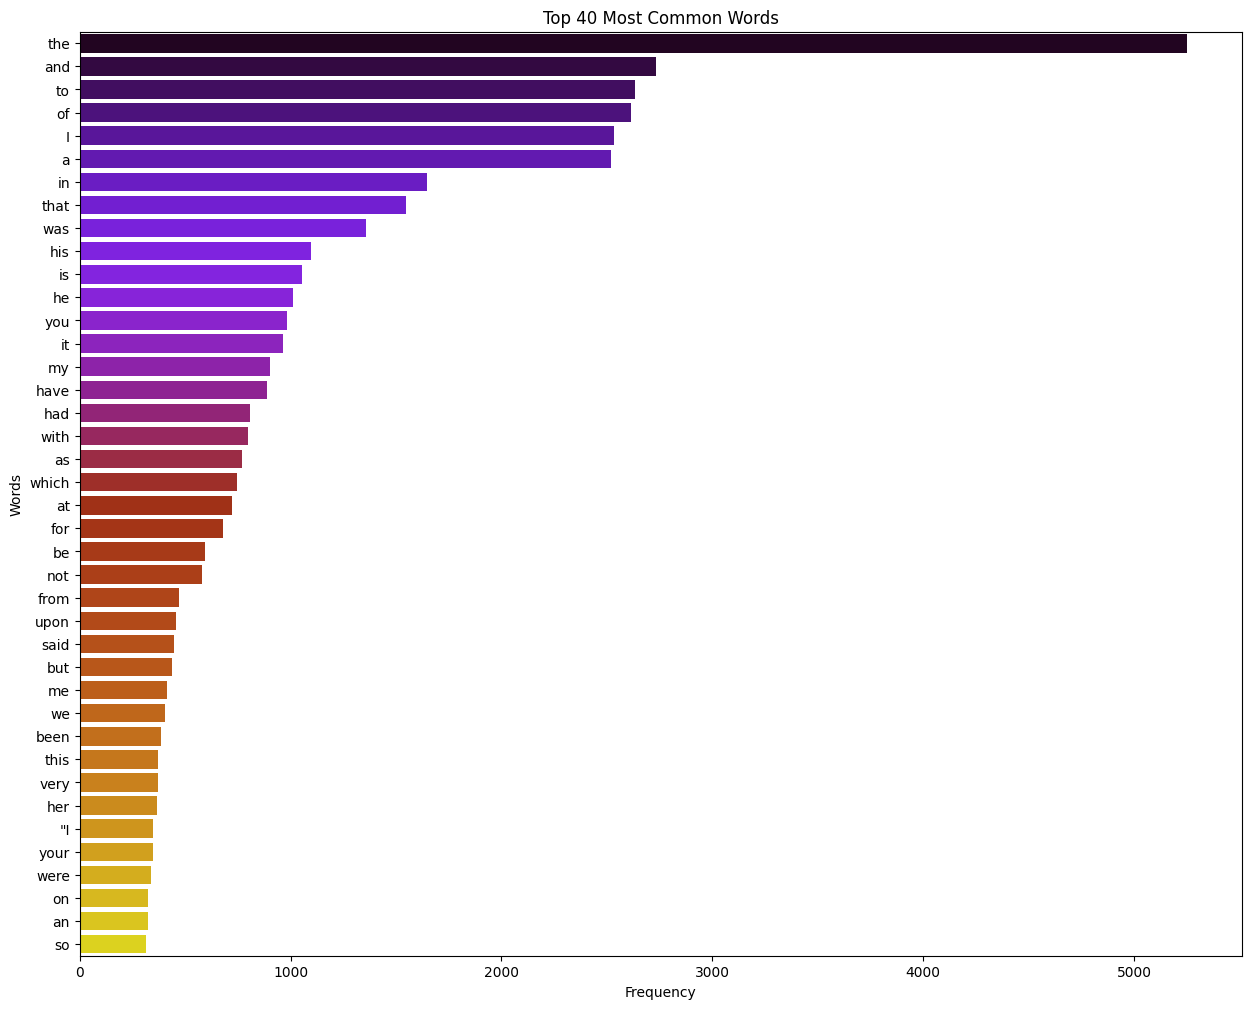

In [6]:
word_freq = Counter(words)
common_words = word_freq.most_common(40)

df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(15,12))
sns.barplot(x='Frequency', y='Word', data=df_common_words, palette="gnuplot")
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 40 Most Common Words')
plt.show()

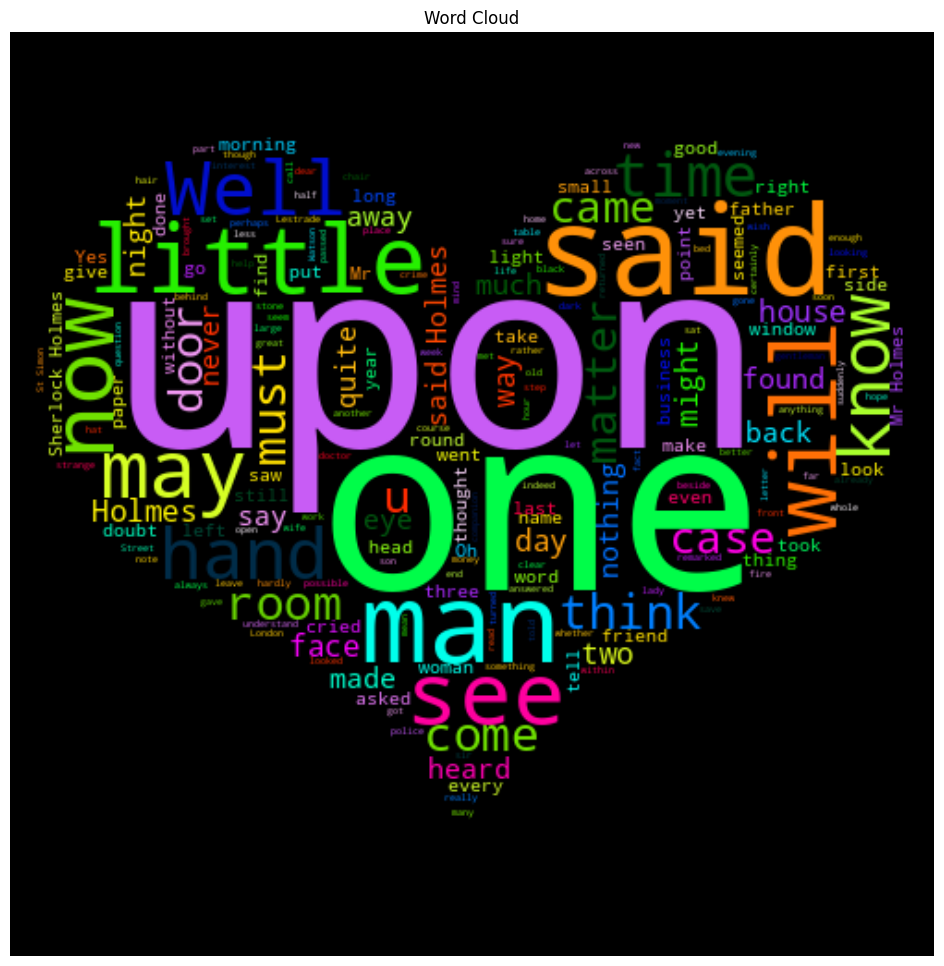

In [7]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='black',mask=mask,colormap="gist_ncar").generate(text)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


In [8]:
import pickle
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1

In [9]:
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
input_sequences=[]
for line in text.split('.'):
    token_list=tokenizer.texts_to_sequences([line])[0]
    for i in range (1,len(token_list)):
        n_gram_sequence = token_list[:i+1] 
        input_sequences.append(n_gram_sequence)

In [11]:
max_sequence_len=max([len(x) for x in input_sequences])
input_sequences= np.array(pad_sequences(input_sequences,maxlen=max_sequence_len,padding='pre'))

In [12]:
train_data=input_sequences[:,:-1]
label_data=input_sequences[:,-1]
label_data=np.array(tf.keras.utils.to_categorical(label_data, num_classes=total_words))

In [13]:
label_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(train_data,label_data, test_size=0.2, random_state=42)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.layers import Embedding, LSTM, Dense,Input


model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=total_words, output_dim=100, input_shape=(max_sequence_len-1,)))
model_rnn.add(SimpleRNN(128, return_sequences=True))  
model_rnn.add(SimpleRNN(64))  
model_rnn.add(Dense(total_words, activation='softmax'))

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       820,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8200)           │       533,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,394,664 (5.32 MB)

 Trainable params: 1,394,664 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history_rnn = model_rnn.fit(train_data, label_data, 
                               epochs=120, 
                               batch_size=64, 
                               verbose=1,
                               callbacks=[reduce_lr, early_stop])


Epoch 1/120
   7/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.0000e+00 - loss: 9.0025

I0000 00:00:1717159951.724517     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.0575 - loss: 6.7898 - learning_rate: 0.0010
Epoch 2/120
   7/1558 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.1324 - loss: 5.8142

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1045 - loss: 5.8488 - learning_rate: 0.0010
Epoch 3/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1241 - loss: 5.5220 - learning_rate: 0.0010
Epoch 4/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1378 - loss: 5.2914 - learning_rate: 0.0010
Epoch 5/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1475 - loss: 5.1255 - learning_rate: 0.0010
Epoch 6/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1577 - loss: 4.9727 - learning_rate: 0.0010
Epoch 7/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1669 - loss: 4.8332 - learning_rate: 0.0010
Epoch 8/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1729 - loss: 4.7055 - learning_rate: 0.0010
Epoch 9/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1846 - loss: 4.5692 - learning_rate: 0.0010
Epoch 10/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.1911 - loss: 4.4506 

In [17]:
model_rnn.save("rnn_model.h5")

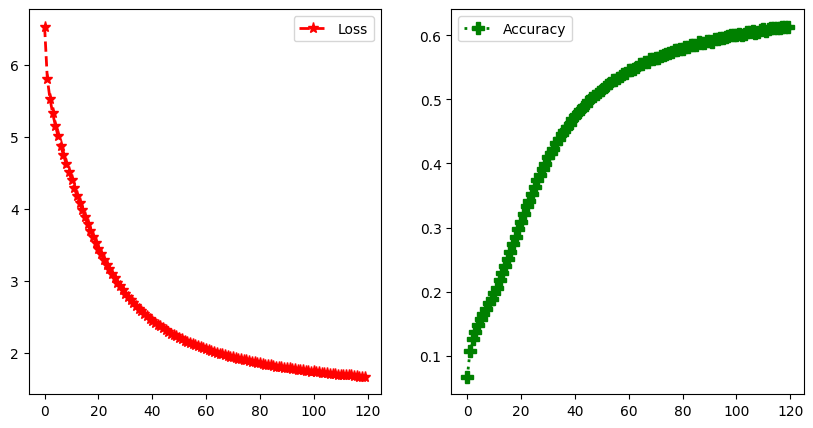

In [18]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss',lw=2,linestyle="--",marker="*",markersize=8,color="red")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy',lw=2,linestyle=":",marker="P",markersize=8,color="green")
    plt.legend()
    plt.show()
plot_history(history_rnn)

In [19]:
def generate_text(model, seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [20]:
seed_text = "It was a brisk autumn afternoon when a perplexing case landed on the desk of Sherlock Holmes"
print(generate_text(model_rnn, seed_text, 20, max_sequence_len))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
It was a brisk autumn afternoon when a perplexing case landed on the desk of Sherlock Holmes and suddenly closed as a calf tawny tinted with hanging jowl black muzzle and huge projecting bones with his lips


In [21]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model_lstm = Sequential()
model_lstm.add(Input(shape=(max_sequence_len-1,)))
model_lstm.add(Embedding(input_dim=total_words, output_dim=100))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(total_words, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       820,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8200)           │       533,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,519,656 (5.80 MB)

 Trainable params: 1,519,656 (5.80 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history_lstm = model_lstm.fit(train_data, label_data, 
                               epochs=120, 
                               batch_size=64, 
                               verbose=1,
                               callbacks=[reduce_lr, early_stop])


Epoch 1/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.0524 - loss: 6.8229 - learning_rate: 0.0010
Epoch 2/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.0866 - loss: 5.9721 - learning_rate: 0.0010
Epoch 3/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.1093 - loss: 5.6979 - learning_rate: 0.0010
Epoch 4/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.1255 - loss: 5.5084 - learning_rate: 0.0010
Epoch 5/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.1397 - loss: 5.3134 - learning_rate: 0.0010
Epoch 6/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.1422 - loss: 5.1755 - learning_rate: 0.0010
Epoch 7/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.1524 - loss: 5.0371 - learning_rate: 0.0010
Epoch 8/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.1566 - loss: 4.9249 - learning_rate: 0.0010
Epoch 9/120
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.1623 - lo

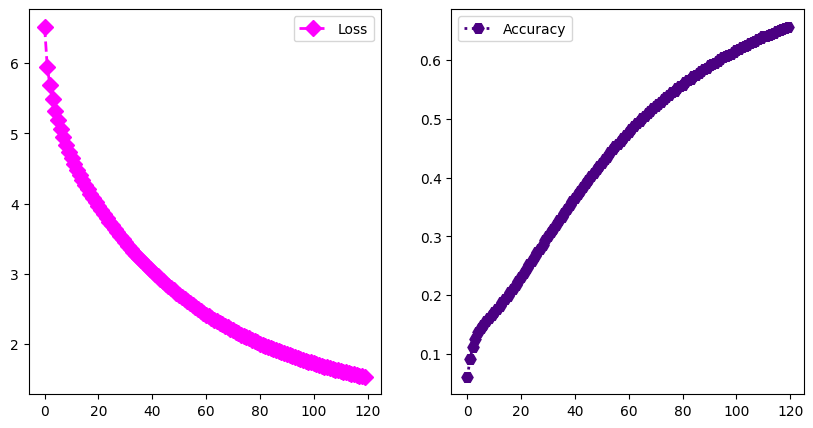

In [23]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss',lw=2,linestyle="--",marker="D",markersize=8,color="magenta")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy',lw=2,linestyle=":",marker="H",markersize=8,color="indigo")
    plt.legend()
    plt.show()
plot_history(history_lstm)

In [24]:
def generate_text(model, seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [25]:
seed_text = "Holmes, with his keen eye for detail, immediately began his investigation."
print(generate_text(model_lstm, seed_text, 20, max_sequence_len))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Holmes, with his keen eye for detail, immediately began his investigation. seemed to her lunch in the testament that turner had been referred to me and hence i was not in
